# Data preprocessing

In [309]:
%run utilspro.py

In [310]:
# Concatenate the two dataframes
combined_clinical_and_suppl = pd.concat([train_clinical_data, supplemental_clinical_data], axis=0)

# Exclude the updrs columns and medication state from the list of columns
columns_to_consider = [col for col in combined_clinical_and_suppl.columns if not col.startswith('updrs') and col != 'upd23b_clinical_state_on_medication']

# Drop duplicates based on the selected columns
unique_df = combined_clinical_and_suppl.drop_duplicates(subset=columns_to_consider)

# count the records of each dataframe
print("Number of records in the original dataframe: {}".format(len(train_clinical_data)))
print("Number of records in the supplemental dataframe: {}".format(len(supplemental_clinical_data)))
print("Number of records in the combined dataframe: {}".format(len(combined_clinical_and_suppl)))
print("Number of records in the unique dataframe: {}".format(len(unique_df)))
print("Number of unique visit_id: {}".format(len(unique_df['visit_id'].unique())))

Number of records in the original dataframe: 2615
Number of records in the supplemental dataframe: 2223
Number of records in the combined dataframe: 4838
Number of records in the unique dataframe: 4838
Number of unique visit_id: 4838


In [311]:
# Merge the dataframes on the common columns
enriched_peptide_data = pd.merge(train_peptides, unique_df, on=['visit_id', 'visit_month', 'patient_id'], how='left')
enriched_protein_data = pd.merge(enriched_peptide_data, train_proteins, on=['visit_id', 'visit_month', 'patient_id','UniProt'], how='left')

# check for null values for  when udprs 3 is not null
enriched_protein_data = enriched_protein_data[enriched_protein_data['updrs_3'].notnull()]
# set the clinical state to off medication for all month 0 and 1,  that have null records
enriched_protein_data.loc[(enriched_protein_data['visit_month'].isin([0,1,2,3])) & (enriched_protein_data['upd23b_clinical_state_on_medication'].isnull()), 'upd23b_clinical_state_on_medication'] = 'Off'

In [312]:
# check the null values for each column
enriched_protein_data.isnull().sum()

visit_id                                    0
visit_month                                 0
patient_id                                  0
UniProt                                     0
Peptide                                     0
PeptideAbundance                            0
updrs_1                                     0
updrs_2                                     0
updrs_3                                     0
updrs_4                                441672
upd23b_clinical_state_on_medication    396104
NPX                                         0
dtype: int64

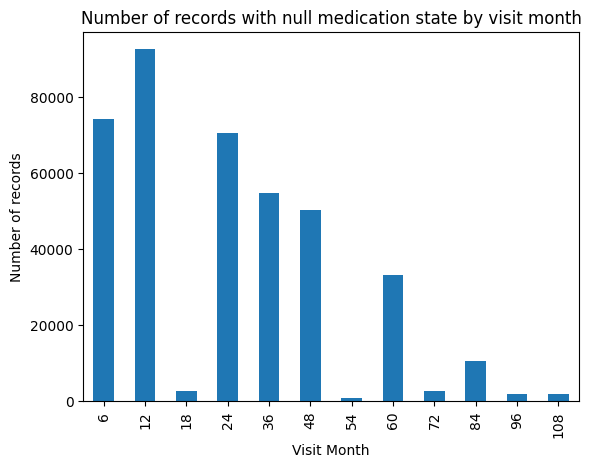

In [299]:
# check the distribution of the month during which medication state is null
# and sort and plot the histogram
enriched_protein_data[enriched_protein_data['upd23b_clinical_state_on_medication'].isnull()]['visit_month'].value_counts().sort_index().plot(kind='bar')
#label the axes and title
plt.xlabel('Visit Month')
plt.ylabel('Number of records')
plt.title('Number of records with null medication state by visit month')
# display the plot
plt.show()


In [313]:
# for medication state null records, check the visit status and set the medication state to that value
# Sort the data by 'patient_id' and 'visit_month'
clinical_data_sorted = enriched_protein_data.sort_values(by=['patient_id', 'visit_month'])

# Forward-fill the 'upd23b_clinical_state_on_medication' column within each 'patient_id' group
clinical_data_sorted['upd23b_clinical_state_on_medication'] = clinical_data_sorted.groupby('patient_id')['upd23b_clinical_state_on_medication'].fillna(method='ffill')

# Check remaining null values in 'upd23b_clinical_state_on_medication'
remaining_nulls = clinical_data_sorted['upd23b_clinical_state_on_medication'].isnull().sum()
remaining_nulls

84711

In [314]:
# Apply backward fill for the remaining null values within each 'patient_id' group
clinical_data_sorted['upd23b_clinical_state_on_medication'] = clinical_data_sorted.groupby('patient_id')['upd23b_clinical_state_on_medication'].fillna(method='bfill')

# Check if there are any more null values in 'upd23b_clinical_state_on_medication'
remaining_nulls_after_bfill = clinical_data_sorted['upd23b_clinical_state_on_medication'].isnull().sum()
remaining_nulls_after_bfill


63683

In [317]:
# check for those patients if the medication state is null for all the records
patients_with_nulls = clinical_data_sorted[clinical_data_sorted['upd23b_clinical_state_on_medication'].isnull()]['patient_id'].unique()
for patient in patients_with_nulls:
    if clinical_data_sorted[clinical_data_sorted['patient_id'] == patient]['upd23b_clinical_state_on_medication'].isnull().sum() == len(clinical_data_sorted[clinical_data_sorted['patient_id'] == patient]):
        print("Patient {} has null values for all records".format(patient))
    else:
        print("Patient {} has null values for some records".format(patient))
# sum all the null values for the medication state
clinical_data_sorted['upd23b_clinical_state_on_medication'].isnull().sum()

Patient 942 has null values for all records
Patient 5036 has null values for all records
Patient 6420 has null values for all records
Patient 7151 has null values for all records
Patient 13360 has null values for all records
Patient 17201 has null values for all records
Patient 20581 has null values for all records
Patient 20707 has null values for all records
Patient 20792 has null values for all records
Patient 23175 has null values for all records
Patient 24818 has null values for all records
Patient 27987 has null values for all records
Patient 31270 has null values for all records
Patient 33108 has null values for all records
Patient 47171 has null values for all records
Patient 51708 has null values for all records
Patient 52119 has null values for all records
Patient 57468 has null values for all records
Patient 58674 has null values for all records
Patient 60788 has null values for all records


63683

In [318]:
# set the medication state to off for all the patients with null medication state
clinical_data_sorted.loc[clinical_data_sorted['upd23b_clinical_state_on_medication'].isnull(), 'upd23b_clinical_state_on_medication'] = 'Off'

# Apply the interpolation function to each patient's data
clinical_data_interpolated = clinical_data_sorted.groupby('patient_id').apply(interpolate_updrs)

# Check remaining null values for UPDRS scores after interpolation
remaining_nulls_updrs_after_interpolation = clinical_data_interpolated[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].isnull().sum()
# Backward fill within each 'patient_id' group
clinical_data_interpolated['updrs_4'] = clinical_data_interpolated.groupby('patient_id')['updrs_4'].fillna(method='bfill')

In [320]:
#check if there are any null values in the medication state column
clinical_data_interpolated.isnull().sum()

visit_id                                    0
visit_month                                 0
patient_id                                  0
UniProt                                     0
Peptide                                     0
PeptideAbundance                            0
updrs_1                                     0
updrs_2                                     0
updrs_3                                     0
updrs_4                                244966
upd23b_clinical_state_on_medication         0
NPX                                         0
dtype: int64

In [321]:
# Forward fill for the remaining null values within each 'patient_id' group
clinical_data_interpolated['updrs_4'] = clinical_data_interpolated.groupby('patient_id')['updrs_4'].fillna(method='ffill')

# If there are still null values, fill them with the median value of the 'updrs_3' column
clinical_data_interpolated['updrs_4'] = clinical_data_interpolated['updrs_4'].fillna(clinical_data_interpolated['updrs_4'].median())

# Check remaining null values for 'updrs_3'
remaining_nulls = clinical_data_interpolated.isnull().sum()
remaining_nulls

visit_id                               0
visit_month                            0
patient_id                             0
UniProt                                0
Peptide                                0
PeptideAbundance                       0
updrs_1                                0
updrs_2                                0
updrs_3                                0
updrs_4                                0
upd23b_clinical_state_on_medication    0
NPX                                    0
dtype: int64

In [322]:
# check the number of records in the enriched dataframe
print("Number of records in the original dataframe: {}".format(len(train_peptides)))
print("Number of records in the enriched dataframe: {}".format(len(clinical_data_interpolated)))

Number of records in the original dataframe: 981834
Number of records in the enriched dataframe: 932624


In [335]:
def dynamic_rolling_average2(grouped_df, col):
    # If there's only one record for the patient, return the original value
    if len(grouped_df) == 1:
        return grouped_df[col]
    
    # Otherwise, compute a rolling average based on available data points
    return grouped_df[col].rolling(window=len(grouped_df), min_periods=1).mean()

# set to not truncate the columns
pd.set_option('display.max_columns', None)

# Sort data by patient_id and visit_month for sequential calculations
clinical_data_sorted_2 = clinical_data_interpolated.sort_values(by=['patient_id', 'visit_month'])

# 1. Time Since Diagnosis
clinical_data_sorted_2['time_since_diagnosis'] = clinical_data_sorted_2.groupby('patient_id')['visit_month'].transform(lambda x: x - x.min())

# Rolling Averages for UPDRS scores over past 2 visits
#for col in ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']:
    #clinical_data_sorted_2[f'{col}_dynamic_rolling_avg'] = clinical_data_sorted_2.groupby('patient_id').apply(dynamic_rolling_average2(col)).reset_index(level=0, drop=True)

# Rate of Change in UPDRS scores from the last visit
#for col in ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']:
    #clinical_data_sorted_2[f'{col}_rate_of_change'] = clinical_data_sorted_2.groupby('patient_id')[col].diff()

# Interaction Feature (time since last visit * medication state)
# Convert medication state to numeric for interaction (On=1, Off=0, NaN stays NaN)
clinical_data_sorted_2['medication_numeric'] = clinical_data_sorted_2['upd23b_clinical_state_on_medication'].map({'On': 1, 'Off': 0})
#clinical_data_sorted_2['time_since_last_visit'] = clinical_data_sorted_2.groupby('patient_id')['visit_month'].diff()
#clinical_data_sorted_2['interaction_feature'] = clinical_data_sorted_2['time_since_last_visit'] * clinical_data_sorted_2['medication_numeric']

# Aggregated Statistics
#for col in ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']:
    #clinical_data_sorted_2[f'{col}_mean'] = clinical_data_sorted_2.groupby('patient_id')[col].transform('mean')
    #clinical_data_sorted_2[f'{col}_median'] = clinical_data_sorted_2.groupby('patient_id')[col].transform('median')
    #clinical_data_sorted[f'{col}_std'] = clinical_data_sorted.groupby('patient_id')[col].transform('std')

# Display the enriched clinical data
clinical_data_sorted_2.head()


,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,NPX,time_since_diagnosis,medication_numeric
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3,10.0,6.0,15.0,0.0,Off,11254.3,0,0
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0,10.0,6.0,15.0,0.0,Off,732430.0,0,0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0,10.0,6.0,15.0,0.0,Off,732430.0,0,0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9,10.0,6.0,15.0,0.0,Off,732430.0,0,0
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7,10.0,6.0,15.0,0.0,Off,732430.0,0,0


In [336]:
clinical_data_sorted_2.isnull().sum()

visit_id                               0
visit_month                            0
patient_id                             0
UniProt                                0
Peptide                                0
PeptideAbundance                       0
updrs_1                                0
updrs_2                                0
updrs_3                                0
updrs_4                                0
upd23b_clinical_state_on_medication    0
NPX                                    0
time_since_diagnosis                   0
medication_numeric                     0
dtype: int64

In [337]:
optimized_info_df_v5(clinical_data_sorted_2)

,Column,Dtype,Null Count,Unique Count,% Missing,1st Mode,2nd Mode,3rd Mode
0,visit_id,object,0,1058,0.0,16574_12,35477_48,35477_60
1,visit_month,int64,0,15,0.0,0,12,24
2,patient_id,int64,0,248,0.0,23391,62723,26210
3,UniProt,object,0,227,0.0,P02787,P02768,P01024
4,Peptide,object,0,968,0.0,AYQGVAAPFPK,YKAAFTEC(UniMod_4)C(UniMod_4)QAADK,TLLSNLEEAK
5,PeptideAbundance,float64,0,710694,0.0,109591.0,127056.0,144004.0
6,updrs_1,float64,0,30,0.0,1.0,2.0,5.0
7,updrs_2,float64,0,29,0.0,0.0,2.0,3.0
8,updrs_3,float64,0,64,0.0,0.0,1.0,2.0
9,updrs_4,float64,0,17,0.0,0.0,4.0,3.0


In [360]:
from sklearn.model_selection import train_test_split
import random

# Baseline model
# We are initially using UPDRS I, UPDRS II, UPDRS IV, 'time_since_diagnosis', 'medication_numeric', 'UniProt_encoded', 'NPX', PeptideAbundance' as predictors. 
# This will be refined using the custom iterative modeling function
clinical_data_sorted_2 = frequency_encode(clinical_data_sorted_2, 'UniProt')
all_features = ['updrs_1', 'updrs_2', 'updrs_4', 'time_since_diagnosis', 'medication_numeric', 'UniProt_encoded' ,'NPX', 'PeptideAbundance']
results = iterative_modeling(clinical_data_sorted_2, all_features)

# Display the results
for metrics in results:
     print(f"Features: {metrics['features']}")
     print(f"Mean Squared Error: {metrics['mse']}")
     print(f"Mean Absolute Error: {metrics['mae']}")
     print(f"R-squared: {metrics['r2']}")
     print("-------------------------")

Features: ['updrs_2', 'updrs_1']
Mean Squared Error: 91.54858649108314
Mean Absolute Error: 7.581576258329232
R-squared: 0.5937078108593925
-------------------------
Features: ['updrs_2', 'updrs_1', 'updrs_4']
Mean Squared Error: 91.54630805990574
Mean Absolute Error: 7.581999822836957
R-squared: 0.5937179225260643
-------------------------
Features: ['updrs_2', 'updrs_1', 'updrs_4', 'time_since_diagnosis']
Mean Squared Error: 91.3306081693479
Mean Absolute Error: 7.594506507265253
R-squared: 0.5946751976090682
-------------------------
Features: ['updrs_2', 'updrs_1', 'updrs_4', 'time_since_diagnosis', 'medication_numeric']
Mean Squared Error: 91.05072653281421
Mean Absolute Error: 7.618706709684271
R-squared: 0.5959173109738507
-------------------------
Features: ['updrs_2', 'updrs_1', 'updrs_4', 'time_since_diagnosis', 'medication_numeric', 'UniProt_encoded']
Mean Squared Error: 91.05074634796644
Mean Absolute Error: 7.618708329481984
R-squared: 0.5959172230343
---------------------

Features: ['PeptideAbundance', 'updrs_1']
Mean Squared Error: 178.8837616362551
Mean Absolute Error: 10.958392673943267
R-squared: 0.20611472112701967
-------------------------
Features: ['PeptideAbundance', 'updrs_1', 'updrs_2']
Mean Squared Error: 91.54844585341797
Mean Absolute Error: 7.5815625956234385
R-squared: 0.5937084350086781
-------------------------
Features: ['PeptideAbundance', 'updrs_1', 'updrs_2', 'updrs_4']
Mean Squared Error: 91.5461658385077
Mean Absolute Error: 7.581986222400894
R-squared: 0.5937185537039489
-------------------------
Features: ['PeptideAbundance', 'updrs_1', 'updrs_2', 'updrs_4', 'time_since_diagnosis']
Mean Squared Error: 91.33043772827297
Mean Absolute Error: 7.594492150092108
R-squared: 0.5946759540257438
-------------------------
Features: ['PeptideAbundance', 'updrs_1', 'updrs_2', 'updrs_4', 'time_since_diagnosis', 'medication_numeric']
Mean Squared Error: 91.05051478326119
Mean Absolute Error: 7.618691629438242
R-squared: 0.5959182507173546
--

c:\Users\User\Desktop\portfolio\NeuroMetrics\.venv\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


<AxesSubplot:>

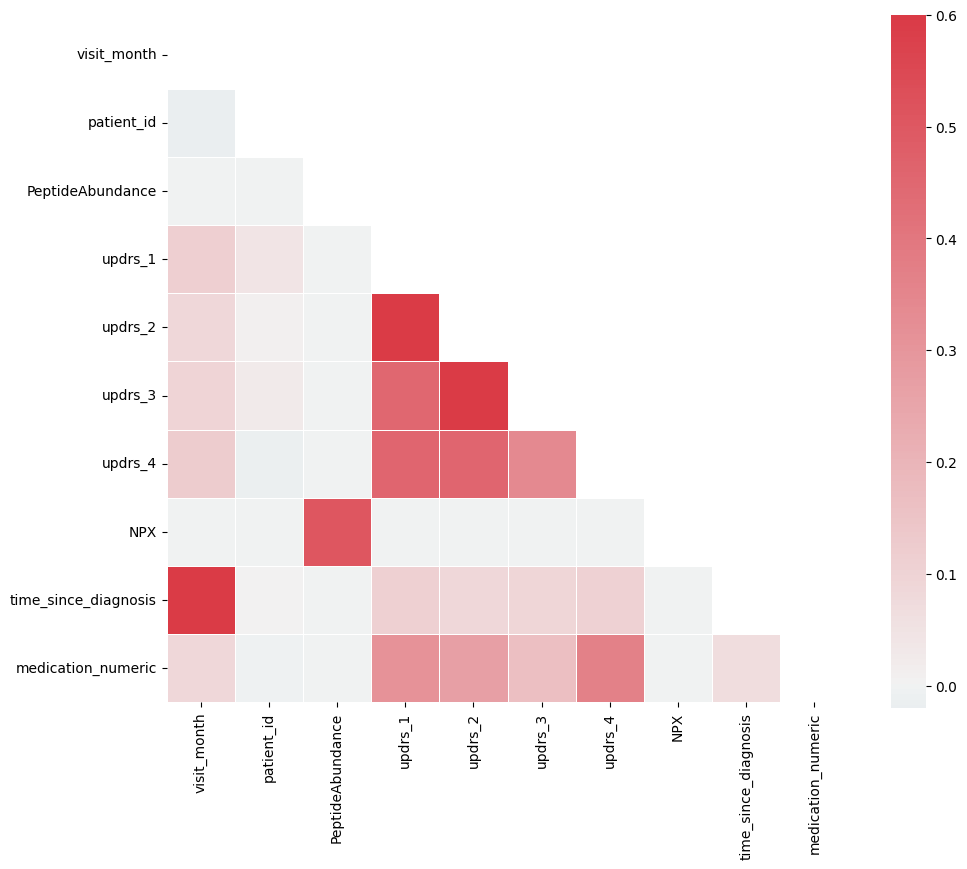

In [338]:
# check for multicollinearity
# Compute the correlation matrix with 
corr = clinical_data_sorted_2.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#plot the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.6, center=0,
            square=True, linewidths=.5)

In [ ]:
to_numeric = ['visit_month', 'patient_id', 'PeptideAbundance', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'NPX', 'time_since_diagnosis', 'medication_numeric', 'updrs_1_mean', 'updrs_1_median', 'updrs_2_mean', 'updrs_2_median', 'updrs_3_mean', 'updrs_3_median', 'updrs_4_mean', 'updrs_4_median']
to_drop = ['visit_id']
to_encode = ['UniProt', 'Peptide', 'upd23b_clinical_state_on_medication']

action_plan = [to_numeric, to_drop, to_encode]

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Columns to be encoded
to_encode = ['UniProt', 'Peptide', 'upd23b_clinical_state_on_medication']

# Columns are already numeric and don't need further transformation
to_numeric = ['visit_month', 'patient_id', 'PeptideAbundance', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 
              'NPX', 'time_since_diagnosis', 'medication_numeric', 'updrs_1_mean', 'updrs_1_median', 
              'updrs_2_mean', 'updrs_2_median', 'updrs_3_mean', 'updrs_3_median', 'updrs_4_mean', 'updrs_4_median']

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', to_numeric),
        ('cat', OneHotEncoder(handle_unknown='ignore'), to_encode)
    ])

# In this case, the pipeline consists only of the preprocessor.
# If you add a machine learning model, you can extend this pipeline further.
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])



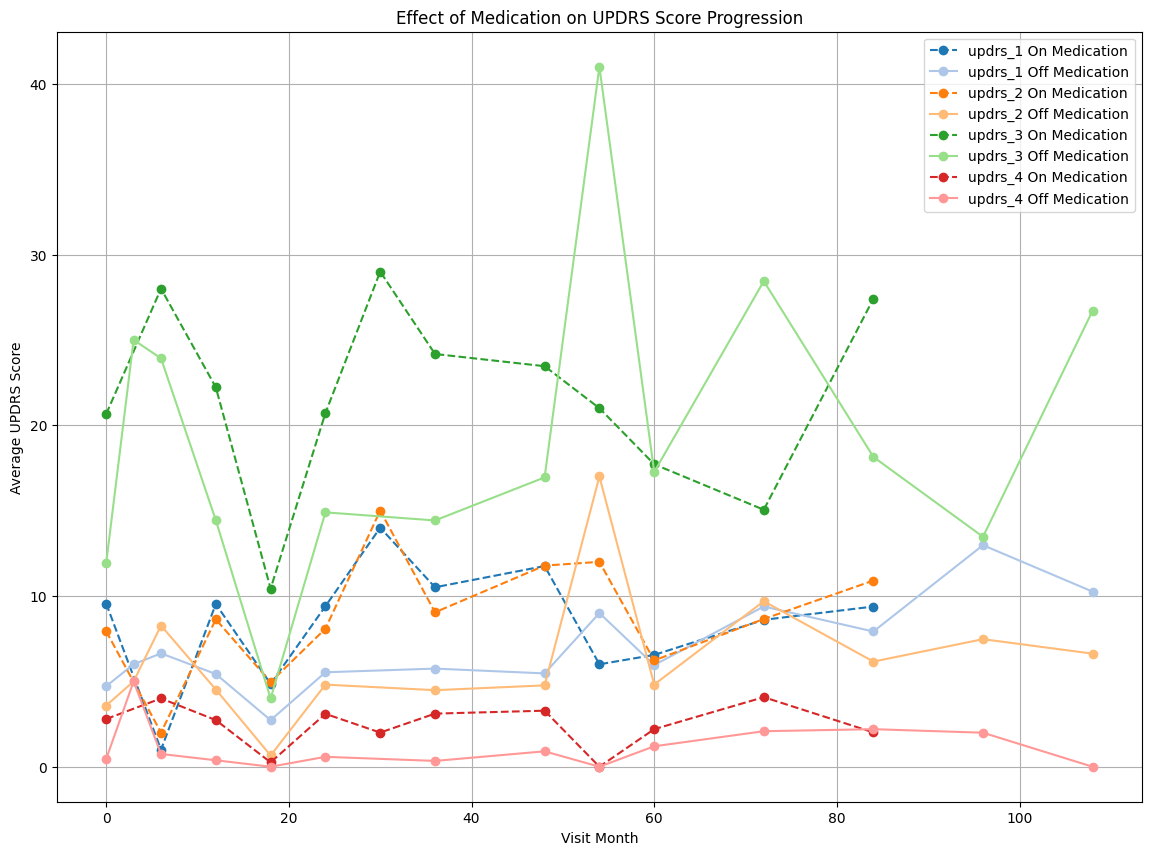

In [247]:
# Segment data based on medication state
on_medication = clinical_data_sorted_2[clinical_data_sorted_2['upd23b_clinical_state_on_medication'] == 'On']
off_medication = clinical_data_sorted_2[clinical_data_sorted_2['upd23b_clinical_state_on_medication'] == 'Off']

# Calculate average UPDRS scores for each visit_month for both medication states
avg_on_medication = on_medication.groupby('visit_month')[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].mean().reset_index()
avg_off_medication = off_medication.groupby('visit_month')[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].mean().reset_index()

# Define gradient colors for each UPDRS number
color_map = {
    'updrs_1': ['#1f77b4', '#aec7e8'],  # blue gradient
    'updrs_2': ['#ff7f0e', '#ffbb78'],  # orange gradient
    'updrs_3': ['#2ca02c', '#98df8a'],  # green gradient
    'updrs_4': ['#d62728', '#ff9896']   # red gradient
}

plt.figure(figsize=(14, 10))
for col in ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']:
    plt.plot(avg_on_medication['visit_month'], avg_on_medication[col], label=f'{col} On Medication', linestyle='--', marker='o', color=color_map[col][0])
    plt.plot(avg_off_medication['visit_month'], avg_off_medication[col], label=f'{col} Off Medication', linestyle='-', marker='o', color=color_map[col][1])

plt.title('Effect of Medication on UPDRS Score Progression')
plt.xlabel('Visit Month')
plt.ylabel('Average UPDRS Score')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#Calculate quartiles for each UniProt group
quartile_df = clinical_data_sorted_2.groupby(['UniProt','visit_month'])['PeptideAbundance'].quantile([0.25, 0.5, 0.75]).unstack()
def categorize_peptide_abundance(row, quartiles):
    uni_quartiles = quartiles.loc[row['UniProt']]
    visit_month_quartiles = uni_quartiles.loc[row['visit_month']]
    return categorize_abundance(row['PeptideAbundance'], visit_month_quartiles)


def fast_categorize_peptide_abundance(df, quartiles):
    # Get quartile values for the current group
    q1 = quartiles.loc[df['UniProt'].iloc[0]].loc[df['visit_month'].iloc[0]].loc[0.25]
    q2 = quartiles.loc[df['UniProt'].iloc[0]].loc[df['visit_month'].iloc[0]].loc[0.50]
    q3 = quartiles.loc[df['UniProt'].iloc[0]].loc[df['visit_month'].iloc[0]].loc[0.75]

    # Use numpy's select for vectorized conditional operation
    conditions = [
        df['PeptideAbundance'] <= q1,
        df['PeptideAbundance'] <= q2,
        df['PeptideAbundance'] <= q3
    ]
    choices = ['low', 'medium', 'high']
    df['AbundanceCategory'] = np.select(conditions, choices, default='very_high')
    return df

# Group by 'UniProt' and 'visit_month' and then apply the function
clinical_data_sorted_2 = clinical_data_sorted_2.groupby(['UniProt', 'visit_month']).apply(fast_categorize_peptide_abundance, quartiles=quartile_df)


In [223]:
# create a function to categorize the protein expression
def categorize_protein_expression(row, quartiles):
    uni_quartiles = quartiles.loc[row['UniProt']]
    visit_month_quartiles = uni_quartiles.loc[row['visit_month']]
    return categorize_abundance(row['ProteinExpression'], visit_month_quartiles)

# Create a fast categorize function for the protein expression (NPX) column
def fast_categorize_protein_expression(df, quartiles):
    # Get quartile values for the current group
    q1 = quartiles.loc[df['UniProt'].iloc[0]].loc[df['visit_month'].iloc[0]].loc[0.25]
    q2 = quartiles.loc[df['UniProt'].iloc[0]].loc[df['visit_month'].iloc[0]].loc[0.50]
    q3 = quartiles.loc[df['UniProt'].iloc[0]].loc[df['visit_month'].iloc[0]].loc[0.75]

    # Use numpy's select for vectorized conditional operation
    conditions = [
        df['ProteinExpression'] <= q1,
        df['ProteinExpression'] <= q2,
        df['ProteinExpression'] <= q3
    ]
    choices = ['low', 'medium', 'high']
    df['ExpressionCategory'] = np.select(conditions, choices, default='very_high')
    return df

# Replace NPX by protein expression
clinical_data_sorted_2.rename(columns={'NPX': 'ProteinExpression'}, inplace=True)

# Group by 'UniProt' and 'visit_month' and then apply the function on protein expression
clinical_data_sorted_2 = clinical_data_sorted_2.groupby(['UniProt', 'visit_month']).apply(fast_categorize_protein_expression, quartiles=quartile_df)

# Display the enriched data
clinical_data_sorted_2.head(2).T


,0,1
visit_id,55_0,55_0
visit_month,0,0
patient_id,55,55
UniProt,O00391,O00533
Peptide,NEQEQPLGQWHLS,GNPEPTFSWTK
PeptideAbundance,11254.3,102060.0
updrs_1,10.0,10.0
updrs_2,6.0,6.0
updrs_3,15.0,15.0
updrs_4,0.0,0.0


In [249]:
clinical_data_sorted_2.isnull().sum()


visit_id                                 0
visit_month                              0
patient_id                               0
UniProt                                  0
Peptide                                  0
PeptideAbundance                         0
updrs_1                                  0
updrs_2                                  0
updrs_3                                  0
updrs_4                                  0
upd23b_clinical_state_on_medication      0
NPX                                      0
time_since_diagnosis                     0
updrs_1_rolling_avg                    248
updrs_2_rolling_avg                    248
updrs_3_rolling_avg                    248
updrs_4_rolling_avg                    248
updrs_1_rate_of_change                 248
updrs_2_rate_of_change                 248
updrs_3_rate_of_change                 248
updrs_4_rate_of_change                 248
medication_numeric                       0
time_since_last_visit                  248
interaction

In [ ]:
# Categorize PeptideAbundance into quartile-based categories
peptide_data['AbundanceCategory'] = peptide_data['PeptideAbundance'].apply(categorize_abundance)

# Create a new identifier combining 'UniProt', 'visit_month', and 'AbundanceCategory'
peptide_data['UniProt_month_category'] = peptide_data['UniProt'] + "_" + peptide_data['visit_month'].astype(str) + "_" + peptide_data['AbundanceCategory']

# Display the relevant columns
peptide_data[['UniProt', 'visit_month', 'PeptideAbundance', 'AbundanceCategory', 'UniProt_month_category']].head()


,UniProt,visit_month,PeptideAbundance,AbundanceCategory,UniProt_month_category
0,O00391,0,11254.3,low,O00391_0_low
1,O00533,0,102060.0,high,O00533_0_high
2,O00533,0,174185.0,high,O00533_0_high
3,O00533,0,27278.9,low,O00533_0_low
4,O00533,0,30838.7,medium,O00533_0_medium


Text(0, 0.5, 'Score Value')

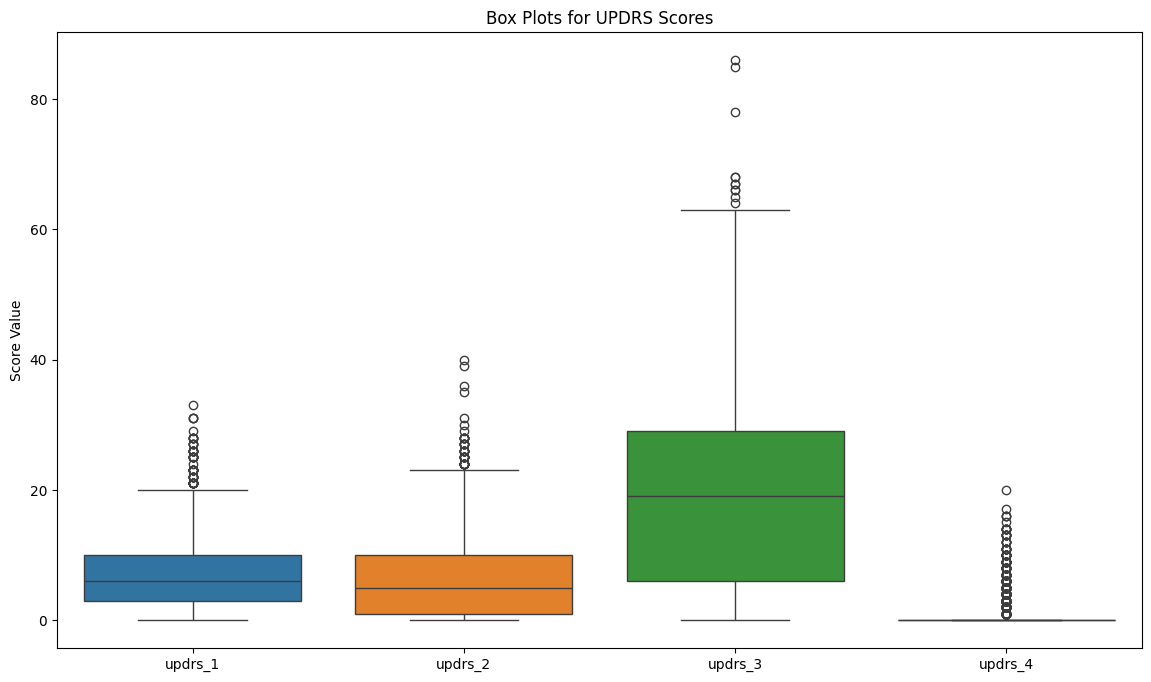

In [ ]:
# Let's visualize the distribution of UPDRS scores using box plots to identify potential outliers.
# Plot box plots for UPDRS scores to visualize outliers
plt.figure(figsize=(14, 8))
sns.boxplot(data=train_clinical_data[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']])
plt.title('Box Plots for UPDRS Scores')
plt.ylabel('Score Value')

There are potential outliers, especially in updrs_3 and updrs_4.
The whiskers of the box plots can help in determining the range beyond which data points are considered outliers.

#### Detecting the outlier by IQR method

In [ ]:
# Compute IQR for each UPDRS score
# Extract UPDRS scores for analysis detection
data_for_outliers = train_clinical_data[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']]
Q1 = data_for_outliers.quantile(0.25)
Q3 = data_for_outliers.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers based on the IQR method
outliers_iqr = ((data_for_outliers < (Q1 - 1.5 * IQR)) | (data_for_outliers > (Q3 + 1.5 * IQR))).any(axis=1)

# Number of outliers identified by IQR method
outliers_iqr.sum()


641

#### Detect outliers by Mahalanobis Distance

In [ ]:
# Extract UPDRS scores for outlier detection
data_for_outliers = train_clinical_data[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']]

# Compute Robust Mahalanobis Distance using Minimum Covariance Determinant (MCD) method
mcd = MinCovDet(random_state=42).fit(data_for_outliers)
robust_mahalanobis_distance = mcd.mahalanobis(data_for_outliers)

# Choose a threshold (e.g., based on chi-squared distribution with df equal to number of features)
from scipy.stats import chi2
threshold_rmd = chi2.ppf((1 - 0.01), df=data_for_outliers.shape[1])  # 99% confidence

# Identify outliers based on the threshold
outliers_rmd = np.where(robust_mahalanobis_distance > threshold_rmd)

# Number of outliers identified by Robust Mahalanobis Distance
len(outliers_rmd[0])


325

In [ ]:
#### Comparing the results of the two methods
# Overlap analysis
outliers_rmd_set = set(outliers_rmd[0])
outliers_iqr_set = set(outliers_iqr[outliers_iqr].index)

# Outliers identified by both methods
common_outliers = outliers_rmd_set.intersection(outliers_iqr_set)

# Outliers identified only by Robust Mahalanobis Distance
only_rmd_outliers = outliers_rmd_set - outliers_iqr_set

# Outliers identified only by IQR method
only_iqr_outliers = outliers_iqr_set - outliers_rmd_set

len(common_outliers), len(only_rmd_outliers), len(only_iqr_outliers)

(204, 121, 437)

* 205 data points are identified as outliers by both methods.
* 123 data points are identified as outliers only by the Robust Mahalanobis Distance method.
* 436 data points are identified as outliers only by the IQR method.
##### Analysis of Potential Data Loss:
If we were to remove the outliers identified by the IQR method (as it identified the most outliers), we'd lose 641 data points, 24.51% of the dataset. This is a significant proportion and could impact the predictive power of the model, especially if some of the removed data points contain crucial information

In [ ]:
# remove outliers using robust mahalanobis distance
train_clinical_data = train_clinical_data.drop(index=only_rmd_outliers) # remove outliers identified by RMD

In [ ]:
train_clinical_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2494 entries, 0 to 2614
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   visit_id                             2494 non-null   object 
 1   patient_id                           2494 non-null   int64  
 2   visit_month                          2494 non-null   int64  
 3   updrs_1                              2494 non-null   float64
 4   updrs_2                              2494 non-null   float64
 5   updrs_3                              2494 non-null   float64
 6   updrs_4                              2494 non-null   float64
 7   upd23b_clinical_state_on_medication  2494 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 175.4+ KB


## 3.  Encoding, Feature Scaling, and Splitting the data 

In [ ]:
# One-hot encoding for the categorical feature
encoded_features = pd.get_dummies(train_clinical_data['upd23b_clinical_state_on_medication'], prefix='medication')

# Combine the UPDRS scores and encoded features
X = pd.concat([train_clinical_data[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']], encoded_features], axis=1)

# Separate the target variable (we'll predict UPDRS Part 3 for this analysis)
y = X.pop('updrs_3')

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape


((1995, 5), (499, 5))

The data has been successfully scaled and encoded. The training set contains 2,092 samples, while the test set contains 523 samples. Each sample has 5 features: updrs_1, updrs_2, updrs_4, and two one-hot encoded features for upd23b_clinical_state_on_medication